# Blind Dating Analysis

File to process and analyze the data from the Blind Dating event.

The main goal is to determine which questions where useful in predicting a good date
based on a number of different outcomes.

Although "dating" might be the ideal outcome, seeing if people found compatability or
a new friend through the process should also be considered a success as the questions
largely asked about personality compatability.

Any findings should be considered in determining which questions to change, add, and remove.

In [8]:
# Importing neccesary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# Importing the datasets

dfPre = pd.read_csv("response.csv", header=None)
dfPost = pd.read_csv("postResponse.csv", header=None)
dfPreference = pd.read_csv("PreferenceList.csv", header=None)

Due to poor planning in the early part of this project, an unideal approach needed to be made regarding receiving questions in the code. Direct indexing is used. The reason the response.csv file has so many blank spaces that aren't just cleared is because it would mess up the indexing process. After this step, everything else follows more naturally.

This block with "qNames" lists all the info regarding what each question is in a shortened form to be referenced in visuals.

In [51]:
# Creating dictionaries to map question numbers to their names
# Responses are formatted as Self vs. Want
# Negative signs (i.e. -58) do not mean a negative index, but rather a polarity flip
qNames = {
    # Emotion
    "Q1": "Cries often VS. Uncofmortable consoling the unwell", # Indices 59 VS. -58
    "Q2": "Tend to be anxious VS. Values self esteem in someone", # Indices 62 VS. -64
    "Q3": "Clearly articulate feelings VS. Clearly articulate feelings", # Indices 50 VS. 50
    "Q4": "Unable to act / trapped in thoughts VS. Unable to act / trapped in thoughts", # Indices 49 VS. 49
    "Q5": "Not embarrassed by others VS. Not embarrassed by others", # Indices 53 VS. 53
    # Conflict
    "Q6": "Shut down when yelled at VS. Heated easily", # Indices 54 VS. -55
    "Q7": "Seek to resolve conflict VS. Sweep issues under the rug", # Indices 56 VS. -57
    "Q8": "Having fun more important than winning VS. Having fun more important than winning", # Indices 60 VS. 60
    "Q9": "Persuaded more by something emotionally VS. Pursuaded more by something emotionally", # Indices 65 VS. 65
    "Q10": "Easy to say sorry VS. Easy to say sorry", # Indices 63 VS. 63
    # Extraversion
    "Q11": "Talk to strangers VS. Likes outgoing people", # Indices 32 VS. 33
    "Q12": "Is center of attention VS. Likes quieter personality", # Indices 36 VS. -39
    "Q13": "Burdened by initiating convrersation VS. Tends to initiate", # Indices 37 VS. 38
    "Q14": "Prefers to be by themselves VS. Prefers to be by themselves", # Indices 40 VS. 40
    "Q15": "Drained at big parties VS. Drained at big parties", # Indices 41 VS. 41
    "Q16": "Uncomfortable in noisy place VS. Uncomfortable in noisy place", # Indices 42 VS. 42
    # Lifestyle
    "Q17": "Seek out new experiences VS. Seek out new experiences", # Indices 34 VS. 34
    "Q18": "Love to be in nature VS. Love to be in nature", # Indices 35 VS. 35
    "Q19": "Bedroom is clean and tidy VS. Messy space is aggravating", # Indices 46 VS. -45
    "Q20": "Enjoys a structured schedule VS. Enjoys a structured schedule", # Indices 47 VS. 47
    "Q21": "Adjusts qick to last minute changes VS. Adjusts qick to last minute changes", # Indices 48 VS. 48
    "Q22": "Enjoy serving others VS. Enjoy serving others", # Indices 75 VS. 75
    "Q23": "Bothered if personally not on time or early VS. Often late", # Indices 74 VS. -88
    "Q24": "Worry about the future VS. Worry about the future", # Indices 44 VS. 44
    "Q25": "Social life over work VS. Social life over work", # Indices 43 VS. 43
    # Communication
    "Q26": "Reserved with emotions VS. Reserved with emotions", # Indices 51 VS. 51
    "Q27": "Speak without thinking VS. Speak without thinking", # Indices 52 VS. 52
    "Q28": "Okay lying to spare feelings VS. Okay lying to spare feelings", # Indices 61 VS. 61
    "Q29": "Great value in gift-giving VS. Not much value in receiving gifts", # Indices 76 VS. -77
    "Q30": "Texting over calls VS. Texting over calls", # Indices 72 VS. 72
    "Q31": "Express verbal appreciation to partner VS. Important to be complimented", # Indices 78 VS. 79
    # Partner Interaction
    "Q32": "Want to act like a couple in public VS. Want to act like a couple in public", # Indices 66 VS. 66
    "Q33": "Tend to be very affectionate VS. Tend to be very affectionate", # Indices 67 VS. 67
    "Q34": "Importance on small physical gestures VS. Importance on small physical gestures", # Indices 68 VS. 68
    "Q35": "Desire a partner who is playful VS. Desire a partner who is playful", # Indices 69 VS. 69
    "Q36": "Don't like getting physical quick VS. Don't like getting physical quick", # Indices 70 VS. 70
    "Q37": "Partner time more important than friend time VS. Partner time more important than friend time", # Indices 73 VS. 73
    # Partner Interaction
    "Q38": "Slapstick [Humor]", # Indices 104 VS. 104
    "Q39": "Sarcasm [Humor]", # Indices 105 VS. 105
    "Q40": "Dark Humor [Humor]", # Indices 106 VS. 106
    "Q41": "Self-Deprecating [Humor]", # Indices 107 VS. 107
    "Q42": "Wordplay/Puns [Humor]", # Indices 108 VS. 108
    "Q43": "Satire [Humor]", # Indices 109 VS. 109
    "Q44": "Deadpan [Humor]", # Indices 110 VS. 110
    "Q45": "Observational Humor [Humor]", # Indices 111 VS. 111
    "Q46": "Absurdist/Nonsensical [Humor]", # Indices 112 VS. 112
    "Q47": "Parody [Humor]", # Indices 113 VS. 113
    "Q48": "Impressions [Humor]", # Indices 114 VS. 114
    "Q49": "Bits [Humor]", # Indices 115 VS. 115
    "Q50": "Witty Banter [Humor]", # Indices 116 VS. 116
    "Q51": "BOTTOM TEXT [Humor]", # Indices 117 VS. 117
    "Q52": "*nuzzles you* [Humor]", # Indices 118 VS. 118
    "Q53": "Brain Rot [Humor]", # Indices 119 VS. 119
    "Q54": "How many booms do you give this survey [Question]", # Indices 120 VS. 120
    "Q55": "Does LOUD equal funny? [Humor]", # Indices 121 VS. 121
    "Q56": "Very long jokes with bad punchlines [Humor]", # Indices 122 VS. 122
    "Q57": "Dad Jokes [Humor]", # Indices 123 VS. 123
    "Q58": "Sexual Innuendo [Humor]", # Indices 124 VS. 124
    "Q59": "Situational Comedy [Humor]", # Indices 125 VS. 125
    "Q60": "Meta Humor [Humor]", # Indices 126 VS. 126
}

This block with "qData" specifies the indicies and polarity explained in the above block. This is used in the creation of the output file.

In [4]:
# Dictionary containing the index for each vector
# [Responder, Date, Polarity]
qData = {
    'Q1': [59, 58, -1],
    'Q2': [62, 64, -1],
    'Q3': [50, 50, 1],
    'Q4': [49, 49, 1],
    'Q5': [53, 53, 1],
    'Q6': [54, 55, -1],
    'Q7': [56, 57, -1],
    'Q8': [60, 60, 1],
    'Q9': [65, 65, 1],
    'Q10': [63, 63, 1],
    'Q11': [32, 33, 1],
    'Q12': [36, 39, -1],
    'Q13': [37, 38, 1],
    'Q14': [40, 40, 1],
    'Q15': [41, 41, 1],
    'Q16': [42, 42, 1],
    'Q17': [34, 34, 1],
    'Q18': [35, 35, 1],
    'Q19': [46, 45, -1],
    'Q20': [47, 47, 1],
    'Q21': [48, 48, 1],
    'Q22': [75, 75, 1],
    'Q23': [74, 88, -1],
    'Q24': [44, 44, 1],
    'Q25': [43, 43, 1],
    'Q26': [51, 51, 1],
    'Q27': [52, 52, 1],
    'Q28': [61, 61, 1],
    'Q29': [76, 77, -1],
    'Q30': [72, 72, 1],
    'Q31': [78, 79, 1],
    'Q32': [66, 66, 1],
    'Q33': [67, 67, 1],
    'Q34': [68, 68, 1],
    'Q35': [69, 69, 1],
    'Q36': [70, 70, 1],
    'Q37': [73, 73, 1],
    'Q38': [104, 104, 1],
    'Q39': [105, 105, 1],
    'Q40': [106, 106, 1],
    'Q41': [107, 107, 1],
    'Q42': [108, 108, 1],
    'Q43': [109, 109, 1],
    'Q44': [110, 110, 1],
    'Q45': [111, 111, 1],
    'Q46': [112, 112, 1],
    'Q47': [113, 113, 1],
    'Q48': [114, 114, 1],
    'Q49': [115, 115, 1],
    'Q50': [116, 116, 1],
    'Q51': [117, 117, 1],
    'Q52': [118, 118, 1],
    'Q53': [119, 119, 1],
    'Q54': [120, 120, 1],
    'Q55': [121, 121, 1],
    'Q56': [122, 122, 1],
    'Q57': [123, 123, 1],
    'Q58': [124, 124, 1],
    'Q59': [125, 125, 1],
    'Q60': [126, 126, 1],
}

# Data Cleaning and Organization

The following block is a little messy, but this is due to the aformentioned issues had with the data collection. However, the result is a dataframe with all of the questions and scores alongside the person's answers to the post-survey questions and their compatability score with their given pairing.


In [5]:
# Get a dataframe exluding the header row
df = dfPost[1:]
# Rename the column names to the header names
df.rename(columns=dfPost.iloc[0], inplace=True)

# Get number of rows in dfPre
numRows = dfPre.shape[0]    # 193
# Create a dictionary of vectors for each preSurvey response
vec = {}
for i in range(0, numRows):
    vec[dfPre.iloc[i][0]] = dfPre.iloc[i][0:].values

#df['Q1'] = vec[df['PersonX (responder)']][59] * vec[df['PersonX (date)']][58] * -1

numRowsDF = df.shape[0]
for i in range(0, numRowsDF):
    personX = df.iloc[i][0]
    date = df.iloc[i][1]
    for j in range(1,61):
        qName = 'Q' + str(j)
        dataVec = qData[qName][0], qData[qName][1], qData[qName][2]
        index1, index2, pol = dataVec[0], dataVec[1], dataVec[2]
        num1 = float(vec[personX][index1]) - 4 # Shifts the input value to be between -3 and 3
        num2 = float(vec[date][index2]) - 4 # Shifts the input value to be between -3 and 3
        score = num1 * num2 * pol
        # Convert score to int
        df.at[i+1, qName] = score
    k = 1
    while k < dfPreference.shape[0]:
        if (dfPreference.iloc[k][0] == personX) and (dfPreference.iloc[k][1] == date):
            df.at[i+1, 'CS_Score'] = dfPreference.iloc[k][2]
        k = k + 1

# If any of the Q cells are not set, set it to 0
for i in range(1, 61):
    qName = 'Q' + str(i)
    df[qName] = df[qName].fillna(0)

# If the CS_Score is not set, remove the row
# df = df.dropna(subset=['CS_Score'])

# Download df as output.csv
df.to_csv('output.csv', index=False)


/var/folders/3b/669k7tt966n4cy3xsv12dgqh0000gn/T/ipykernel_37316/3225283085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=dfPost.iloc[0], inplace=True)
/var/folders/3b/669k7tt966n4cy3xsv12dgqh0000gn/T/ipykernel_37316/3225283085.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  personX = df.iloc[i][0]
/var/folders/3b/669k7tt966n4cy3xsv12dgqh0000gn/T/ipykernel_37316/3225283085.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

# Multivariate Linear Regression



Using Multivariate Linear regression on a number of different post-survey questions.

In [6]:
# Creating a vector of all Q's. This will be used many times
qVec = []
for i in range(1, 61):
    qName = 'Q' + str(i)
    qVec.append(qName)

Comparing all question to the post-survey question "Did you enjoy your date?'


Top 5 coefficients:
      Coefficient
Q31     0.246499
Q12     0.184776
Q40     0.181534
Q55     0.151444
Q29     0.132595

Bottom 5 coefficients:
      Coefficient
Q32    -0.128489
Q21    -0.140538
Q19    -0.167052
Q1     -0.189905
Q2     -0.327522

Closest to 0 coefficients:
      Coefficient
Q37    -0.000881
Q6      0.001580
Q5     -0.002086
Q59    -0.004382
Q3     -0.006955


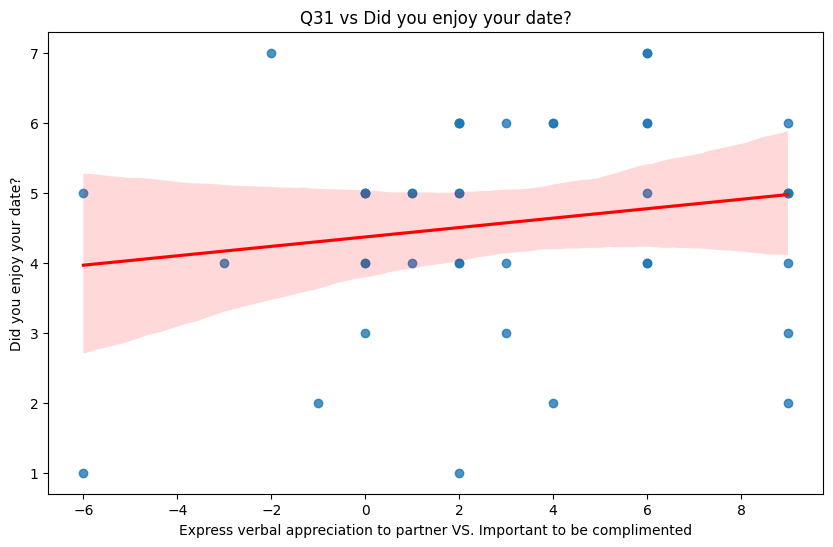

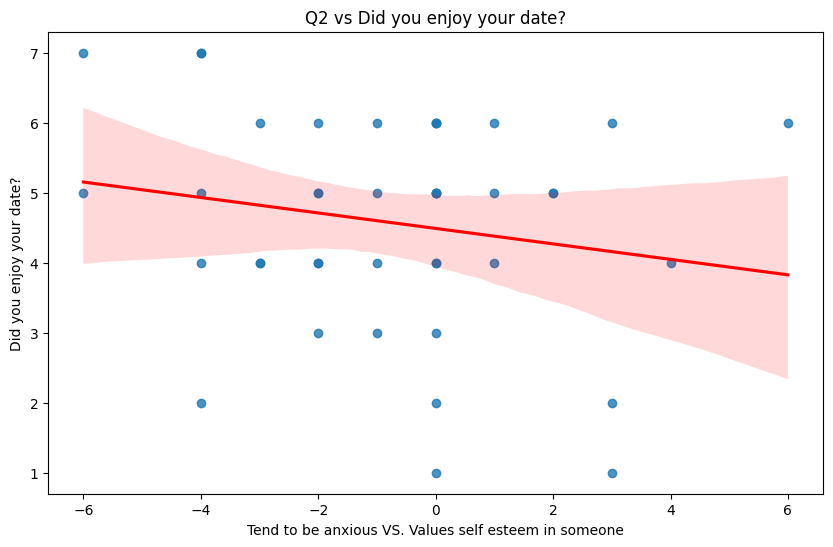

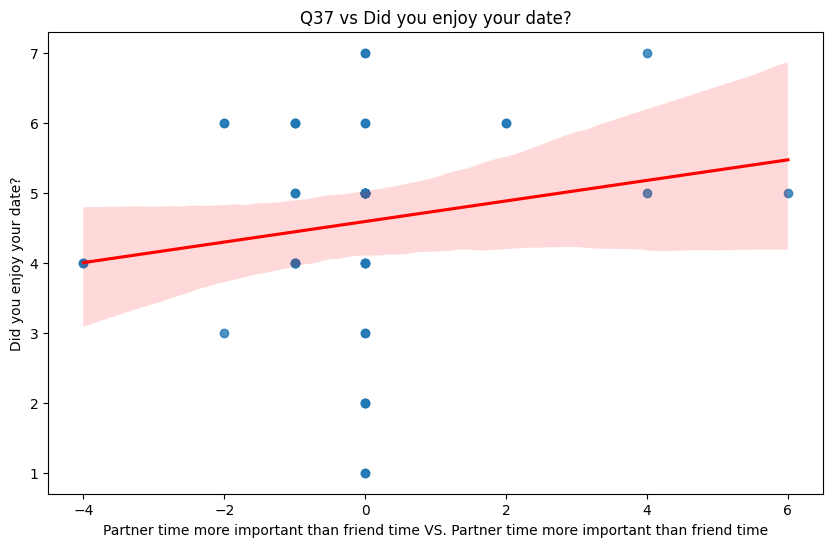

In [65]:
# Assign the X and y variables. X is all 1-60Qs and y is the the 'Did you enjoy your date?' column
X = df[qVec]
y = df['Did you enjoy your date?'].astype(float)

# Split the data into training and testing sets, then fit it to the Linear Regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print the coefficients in order of weight
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
# Print the 5 highest coefficients, the 5 lowest coefficients, and the 5 closest to 0
print("Top 5 coefficients:\n", coefficients.head(5))
print("\nBottom 5 coefficients:\n", coefficients.tail(5))
print("\nClosest to 0 coefficients:\n", coefficients.iloc[(coefficients['Coefficient'] - 0).abs().argsort()[:5]])

# Plot a graph of Q31 vs y with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=X['Q31'], y=y, line_kws={"color": "red"}, ci=95)
plt.xlabel(qNames['Q31'])
plt.ylabel('Did you enjoy your date?')
plt.title('Q31 vs Did you enjoy your date?')
#plt.savefig('Q31_vs_y.png')    # Only needed once
plt.show()


# Plot a graph of Q2 vs y with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=X['Q2'], y=y, line_kws={"color": "red"}, ci=95)
plt.xlabel(qNames['Q2'])
plt.ylabel('Did you enjoy your date?')
plt.title('Q2 vs Did you enjoy your date?')
#plt.savefig('Q2_vs_y.png')   # Only needed once
plt.show()

# Plot a graph of Q37 vs y with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=X['Q37'], y=y, line_kws={"color": "red"}, ci=95)
plt.xlabel(qNames['Q37'])
plt.ylabel('Did you enjoy your date?')
plt.title('Q37 vs Did you enjoy your date?')
#plt.savefig('Q37_vs_y.png')    # Only needed once
plt.show()